# Unpooled Bayesian IDM

<img src="../Figs/Unpooled_B_IDM_PGM.png" width="480">

In [1]:
import arviz as az
import numpy as np
"""
# If pymc3
"""
# import pymc3 as pm
# from theano import tensor as tt
"""
# If pymc4
"""
import pymc as pm
import aesara.tensor as tt

import random
import os
import sys
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

sys.path.append('../')

from data.data_loader import read_training_data
from config import Config
from os import path

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1116)

In [2]:
def load_training_data(base_path, step, min_traj_lenth, pair_id_list):
    tracks = read_training_data(base_path=base_path, min_traj_lenth=min_traj_lenth)
    pair_id = pair_id_list
    
    vt = tracks[pair_id]['vFollReal']
    s = tracks[pair_id]['sReal']
    dv = tracks[pair_id]['dvReal']
    label_v = tracks[pair_id]['vFollReal_next']
    
    if step!=1:
        vt = vt[0::step]
        s = s[0::step]
        dv = dv[0::step]
        label_v = label_v[0::step]
    
    print("Traj lenth:",min_traj_lenth*Config.dt, ", ID list:", pair_id_list, ", Data size:", label_v.shape)
    return vt, s, dv, label_v

def Bayesian_IDM_pool(base_path):
    vt, s, dv, label_v = load_training_data(base_path, step=1, min_traj_lenth=50 * Config.frame_rate_orignial,
                                               pair_id_list=Config.truck_interactive_pair_list[0])
    
    print("training size:", label_v.shape[0])
    dt = Config.dt

    model = pm.Model()

    D = 5
    
    with model:
        def IDM_v(VMAX, DSAFE, TSAFE, AMAX, AMIN, DELTA, s, vt, dv):
            sn = DSAFE + vt * TSAFE + vt * dv / (2 * np.sqrt(AMAX * AMIN))
            a = AMAX * (1 - (vt / VMAX) ** DELTA - (sn / s) ** 2)
            return vt + a * Config.dt

        mu_prior = pm.floatX(np.array([0,0,0,0,0]))
        parameters_normalized = pm.MvNormal('mu_normalized', mu_prior, chol=np.eye(D))
    
        log_parameters = pm.Deterministic('log_mu', parameters_normalized*np.array([.3, 1., 1., .5, .5])
                                      +np.array([2., 0.69, 0.47, -.3, .51]))
        parameters = pm.Deterministic('mu', tt.exp(log_parameters))
        
        DELTA = 4
        
        s_a = pm.Exponential('s_a', lam=1e4)
        
        v_obs = pm.Normal('obs', mu=IDM_v(parameters[0], parameters[1], parameters[2], parameters[3],
                                          parameters[4], DELTA, s, vt, dv), sigma=s_a*dt, observed=label_v)

        tr = pm.sample(2500, tune=5000, random_seed=16, init='jitter+adapt_diag_grad', chains=1,
                       cores=8, discard_tuned_samples=True, return_inferencedata=True, target_accept=0.90)
    return tr, model

In [3]:
base_path = '../data/highD/'
tr, model = Bayesian_IDM_pool(base_path)

Traj lenth: 250.0 , ID list: 3 , Data size: (319,)
training size: 319


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag_grad...
Sequential sampling (1 chains in 1 job)
NUTS: [mu_normalized, s_a]


Sampling 1 chain for 5_000 tune and 2_500 draw iterations (5_000 + 2_500 draws total) took 14 seconds.


In [4]:
import pickle
from pickle import UnpicklingError

base_path = '../data/highD/'

cache = "../PGM_highD/cache/Bayesian_IDM_unpool_truck.pkl"
if path.exists(cache):
    try:
        fp = open(cache, 'rb')
        tr = pickle.load(fp)
        fp.close()
        print("Load trace", cache, ": done!")
    except UnpicklingError:
        os.remove(cache)
        print('Removed broken cache:', cache)
else:
    output_file = open(cache, 'wb')
    pickle.dump(tr, output_file)
    output_file.close()
    print("Generated and Saved", output_file, ": done!")

Generated and Saved <_io.BufferedWriter name='../PGM_highD/cache/Bayesian_IDM_unpool_truck.pkl'> : done!


In [5]:
tr.posterior.s_a.mean(axis=0).mean(axis=0)

<xarray.DataArray 's_a' ()>
array(0.10998232)

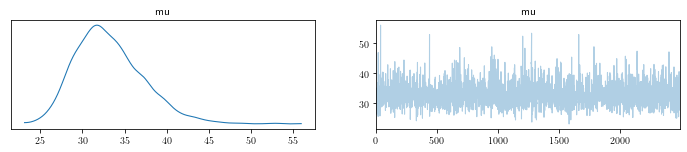

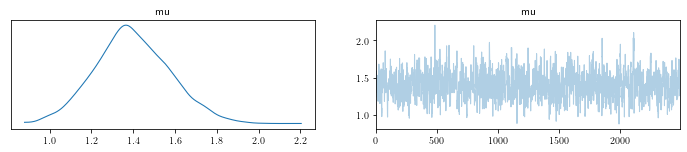

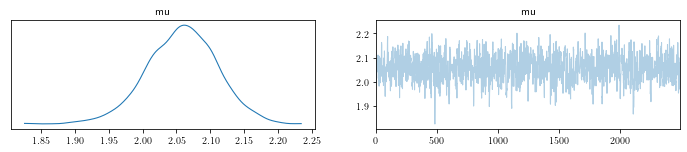

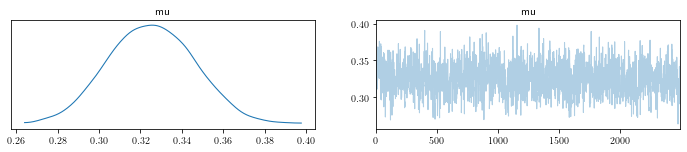

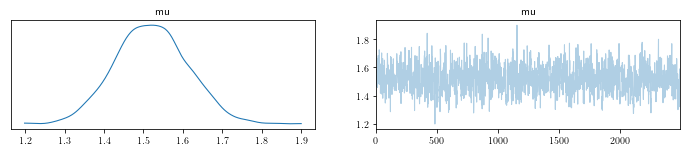

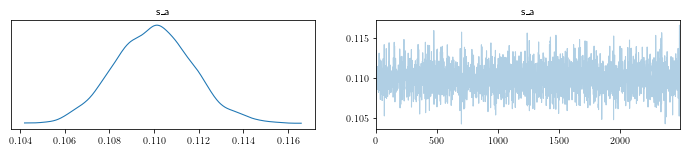

In [6]:
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":0}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":1}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":2}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":3}, compact=True)
_ = az.plot_trace(tr, var_names=["mu"], coords={"mu_dim_0":4}, compact=True)
_ = az.plot_trace(tr, var_names=["s_a"], compact=True)

In [7]:
az.summary(tr, var_names=["mu","log_mu","s_a"])

arviz - WARNING - Shape validation failed: input_shape: (1, 2500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],33.189,4.104,26.087,40.541,0.091,0.066,2255.0,1525.0,NaN
mu[1],1.400,0.183,1.068,1.751,0.006,0.004,884.0,838.0,NaN
mu[2],2.058,0.052,1.956,2.152,0.002,0.001,890.0,874.0,NaN
mu[3],0.325,0.021,0.287,0.364,0.001,0.000,1230.0,1400.0,NaN
mu[4],1.521,0.092,1.346,1.685,0.003,0.002,840.0,983.0,NaN
log_mu[0],3.495,0.120,3.271,3.711,0.003,0.002,2255.0,1525.0,NaN
log_mu[1],0.328,0.131,0.079,0.569,0.004,0.003,884.0,838.0,NaN
log_mu[2],0.721,0.025,0.675,0.770,0.001,0.001,890.0,874.0,NaN
log_mu[3],-1.125,0.064,-1.239,-1.002,0.002,0.001,1230.0,1400.0,NaN
log_mu[4],0.417,0.060,0.299,0.524,0.002,0.001,840.0,983.0,NaN


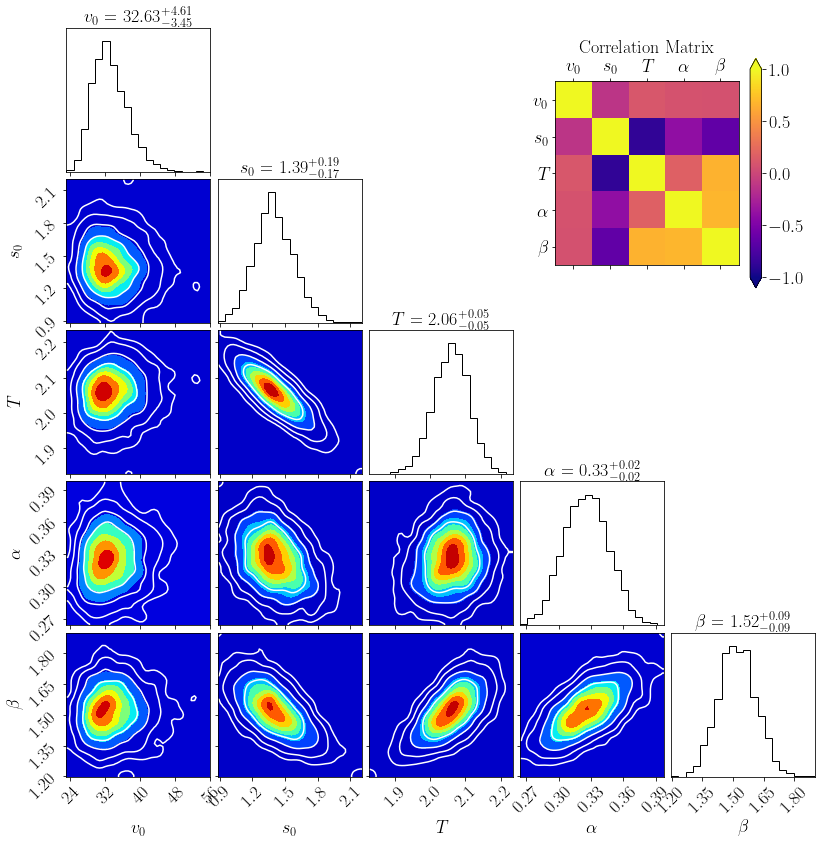

In [8]:
import corner
import matplotlib

label_list = [r'$v_0$',r'$s_0$', r'$T$', r'$\alpha$', r'$\beta$']
fontsize = 18
matplotlib.rc('xtick', labelsize=fontsize) 
matplotlib.rc('ytick', labelsize=fontsize) 

figure = corner.corner(
    tr,
    var_names=['mu'],
    smooth=1.8,
    color = 'k',
    plot_contours=True,
    plot_density=False,
    plot_datapoints = False,
    bins = 20,
    show_titles=True,
    labels=label_list,
    reverse=False,
)

ax_new = figure.add_axes([.66, .66, .27, .27])
cov = np.cov(tr.posterior.mu[0,:,:], rowvar=False)
Dinv = np.diag(1 / np.sqrt(np.diag(cov)))
corr = Dinv @ cov @ Dinv
kwargs = {'cmap':'plasma','interpolation':'nearest', 'vmin':-1}
corr_show = ax_new.matshow(corr, **kwargs)
c_bar = figure.colorbar(corr_show, ax=ax_new, extend='both')
ax_new.set_xticklabels(['']+label_list)
ax_new.set_yticklabels(['']+label_list)
ax_new.set_title('Correlation Matrix')
for item in ([ax_new.title, ax_new.xaxis.label, ax_new.yaxis.label] +
             ax_new.get_xticklabels() + ax_new.get_yticklabels()):
    item.set_fontsize(fontsize)

# figure.savefig('../Figs/B_IDM_unpool_truck.pdf', dpi=300)